In [1]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from tqdm import tqdm

c:\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [3]:
# Create Tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [4]:
# Create LLM that can call tools 
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

In [5]:
sys_msg = SystemMessage(content="Do the required arithmetic using tools")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


In [19]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", "assistant")
builder.add_edge("assistant", END)
#builder.add_edge("tools", END)

memory = InMemorySaver()
react_graph = builder.compile(interrupt_before=["tools"], checkpointer= memory)


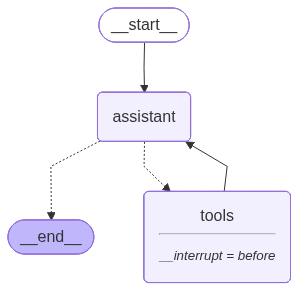

In [8]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

### Example with Tool call and interruption

In [16]:
# Thread
thread = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="Add 3 and 4")]
response = react_graph.invoke({"messages": messages}, thread)

In [17]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_gt9zE8lfr7LzN0C9RuVr9r6j)
 Call ID: call_gt9zE8lfr7LzN0C9RuVr9r6j
  Args:
    a: 3
    b: 4


In [11]:
state = react_graph.get_state(thread)
print(state.next)

('tools',)


In [18]:
# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    response = react_graph.invoke(None, thread)
    for message in response['messages']:
        message.pretty_print()
else:
    print("Sorry!! Operation cancelled by user.")

Sorry!! Operation cancelled by user.


### Example without tool call

In [20]:
thread = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="what is the capital of Germany")]
response = react_graph.invoke({"messages": messages}, thread)

In [21]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the capital of Germany
================================== Ai Message ==================================

The capital of Germany is Berlin.
